# 2x2 Coupler Optimization

This example builds on the `coupler_2x2` notebook to fine-tune the gap width so that we get a nice 50/50 split.

In [1]:
import gdsfactory as gf
import gdsfactory.simulation.gmeep as gm
import gdsfactory.simulation as sim
import matplotlib.pyplot as plt
import meep as mp
import numpy as np
from scipy.optimize import root_scalar
from gdsfactory.simulation.modes import find_modes_waveguide

Using MPI version 4.0, 1 processes


Our setup is pretty much the same as before...

In [2]:
sim_res = 30
n_si = 3.4777
n_sio2 = 1.444
z_wvg = 0.22
lambda0 = 1.55
n_wvls = 101

port_symmetries = {
    "o1@0,o1@0": ["o2@0,o2@0", "o3@0,o3@0", "o4@0,o4@0"],
    "o2@0,o1@0": ["o1@0,o2@0", "o3@0,o4@0", "o4@0,o3@0"],
    "o3@0,o1@0": ["o1@0,o3@0", "o2@0,o4@0", "o4@0,o2@0"],
    "o4@0,o1@0": ["o1@0,o4@0", "o2@0,o3@0", "o3@0,o2@0"],
}

neff = find_modes_waveguide(
    parity=mp.ODD_Y + mp.EVEN_Z,  # TE
    wg_width=0.5,
    ncore=n_si,
    nclad=n_sio2,
    wg_thickness=z_wvg,
    resolution=2 * sim_res,
    sy=6,
    sz=4,
    nmodes=1,
)[1].neff

2023-03-09 17:17:36.928 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 17:17:47.864 | WARNING  | gdsfactory.config:showwarning:60 - Casting complex values to real discards the imaginary part
/users/tfp/yaugenst/dev/code/gf_fork/gdsfactory/typings.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(val, dtype=cls.inner_type)


But now we need to define an objective for our "optimization". We will be looking at the imbalance of the splitting ratios between the two output ports at the target wavelength as a function of the gap size. This is a nice scalar function (at a single wavelength) with a single sign change - perfect for a root finding algorithm!

In [3]:
state_dict = {"cur_iter": 0, "hist": []}  # result cache


def objective(gap):
    c = gf.components.coupler(length=8, gap=gap)

    fp = gm.write_sparameters_meep_mpi(
        component=c,
        port_source_names=["o1"],
        resolution=sim_res,
        wavelength_start=lambda0 - 0.1,
        wavelength_stop=lambda0 + 0.1,
        wavelength_points=n_wvls,  # so that lambda0 is included!
        is_3d=False,
        material_name_to_meep={"si": float(neff), "sio2": n_sio2},
        cores=8,
        port_symmetries=port_symmetries,
        overwrite=True,
    )
    sp = np.load(fp)

    p13 = np.abs(sp["o1@0,o3@0"]) ** 2
    p14 = np.abs(sp["o1@0,o4@0"]) ** 2

    imbalance = 10 * np.log10(1 - (p13 - p14))
    imbalance_fcen = imbalance[n_wvls // 2]

    print(f'iter {state_dict["cur_iter"]:>2d}: {imbalance_fcen=:.3f}, {gap=}')

    state_dict["hist"].append(sp)
    state_dict["cur_iter"] += 1

    return imbalance_fcen

epsilon: 2.08514-12.0944, mean 2.13105, harm. mean 2.09362, 100% > 1, 0.458719% "fill"
Using MPI version 4.0, 8 processes

Elapsed run time = 49.1458 s

2023-03-09 17:17:50.190 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 17:17:50.190 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 17:17:50.191 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 17:17:50.193 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 17:17:50.196 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 17:17:50.197 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 17:17:50.197 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 17:17:50.198 | WARNING  | gdsfactory.pdk:get_

Now we can do the root finding. We will look at gap sizes between 50nm and 150nm as we know that this is roughly where our optimal splitting should occur, and for good measure we will provide our previous gap of 130nm as an initial guess.

In [4]:
sol = root_scalar(
    objective,
    method="brentq",
    bracket=[0.05, 0.15],
    x0=0.13,
    xtol=1e-3,
)
print(sol)

Nice, that took only 8 simulations - let's visualize the solution!

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


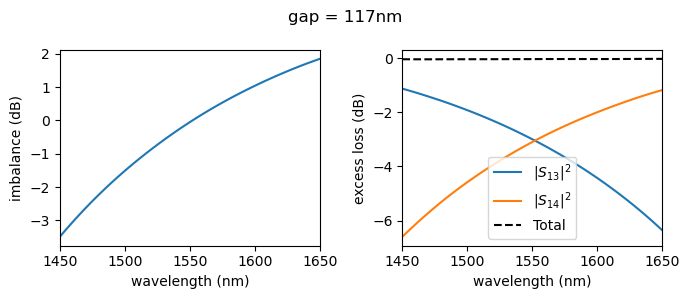

In [6]:
sp = state_dict["hist"][-1]

fig, ax = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle(f"gap = {int(1000*sol.root)}nm")
sim.plot.plot_imbalance2x2(sp, ax=ax[0])
sim.plot.plot_loss2x2(sp, ax=ax[1])
fig.tight_layout()
plt.show()

Finally, let's have a quick look at the total loss.

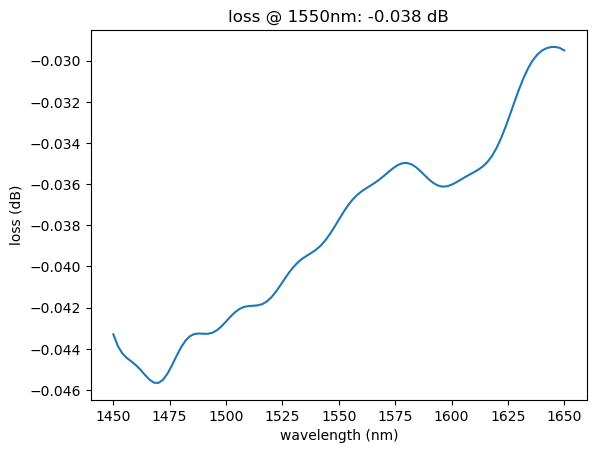

In [15]:
p13 = np.abs(sp["o1@0,o3@0"]) ** 2
p14 = np.abs(sp["o1@0,o4@0"]) ** 2
loss = 10 * np.log10(p13 + p14)

plt.plot(1000 * sp["wavelengths"], loss)
plt.title(f"loss @ 1550nm: {loss[n_wvls // 2]:.3f} dB")
plt.xlabel("wavelength (nm)")
plt.ylabel("loss (dB)")
plt.show()